In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from neo4j import __version__ as neo4j_version,  GraphDatabase
#class is adapted from https://towardsdatascience.com/neo4j-cypher-python-7a919a372be7
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None, **kwargs):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, **kwargs))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response
    
#connect to database
conn = Neo4jConnection(uri="bolt://localhost:7687", user="neo4j", pwd="yTJutYQ$$d%!9h")

##to export terminal : jupyter nbconvert domain_threshold.ipynb --to slides --no-prompt --TagRemovePreprocessor.remove_input_tags={\"remove-input\"} --SlidesExporter.reveal_theme=simple

In [17]:
db_path = "/raid/MattC/repos/ProCogGraphData/procoggraph_20240528" #this should be taken from the config file eventually
analysis_output_path = "/raid/MattC/repos/ProCogGraphData/analysis/notebooks/"

In [4]:
def gini(lis):
    """Calculate the Gini coefficient of a numpy array."""
    array = np.array(lis)
    # From https://github.com/oliviaguest/gini
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

In [5]:
scop = pd.read_csv("/raid/MattC/repos/ProCogGraphData/procoggraph_20240528/contacts/scop_pdb_residue_interactions.csv.gz", na_values = ["NaN", "None"], keep_default_na = False, dtype = {"bound_ligand_residue_interactions":"str", "bound_entity_pdb_residues": "str"}, sep = "\t")
cath = pd.read_csv("/raid/MattC/repos/ProCogGraphData/procoggraph_20240528/contacts/cath_pdb_residue_interactions.csv.gz", na_values = ["NaN", "None"], keep_default_na = False, dtype = {"bound_ligand_residue_interactions":"str", "bound_entity_pdb_residues": "str"}, sep = "\t")
#scop2_fa = pd.read_csv("/raid/MattC/repos/ProCogGraphData/procoggraph_20240528/contacts/scop2_fa_pdb_residue_interactions.csv.gz", na_values = ["NaN", "None"], keep_default_na = False, dtype = {"bound_ligand_residue_interactions":"str", "bound_entity_pdb_residues": "str"}, sep = "\t")
scop2_sf = pd.read_csv("/raid/MattC/repos/ProCogGraphData/procoggraph_20240528/contacts/scop2_sf_pdb_residue_interactions.csv.gz", na_values = ["NaN", "None"], keep_default_na = False, dtype = {"bound_ligand_residue_interactions":"str", "bound_entity_pdb_residues": "str"}, sep = "\t")
pfam = pd.read_csv("/raid/MattC/repos/ProCogGraphData/procoggraph_20240528/contacts/pfam_pdb_residue_interactions.csv.gz", na_values = ["NaN", "None"], keep_default_na = False, dtype = {"bound_ligand_residue_interactions":"str", "bound_entity_pdb_residues": "str"}, sep = "\t")
gene3dsa = pd.read_csv("/raid/MattC/repos/ProCogGraphData/procoggraph_20240528/contacts/gene3dsa_pdb_residue_interactions.csv.gz", na_values = ["NaN", "None"], keep_default_na = False, dtype = {"bound_ligand_residue_interactions":"str", "bound_entity_pdb_residues": "str"}, sep = "\t")
superfamily = pd.read_csv("/raid/MattC/repos/ProCogGraphData/procoggraph_20240528/contacts/superfamily_pdb_residue_interactions.csv.gz", na_values = ["NaN", "None"], keep_default_na = False, dtype = {"bound_ligand_residue_interactions":"str", "bound_entity_pdb_residues": "str"}, sep = "\t")

## Domain-Ligand Interaction Characterisation

First of all, will investigate the general trend of interaction of domains with ligands - are they mostly bound uniquely, by 2 or more domains? Are trends consistent across all databases?

In [15]:
scop_mean_domain_perc = scop[["uniqueID", "domain_contact_perc", "domain_accession", "xref_db"]].groupby(["uniqueID", "xref_db"]).agg({"domain_contact_perc": "mean", "domain_accession": "nunique"}).rename(columns = {"domain_accession": "num_domains"}).reset_index()
cath_mean_domain_perc = cath[["uniqueID", "domain_contact_perc", "domain_accession", "xref_db"]].groupby(["uniqueID", "xref_db"]).agg({"domain_contact_perc": "mean", "domain_accession": "nunique"}).rename(columns = {"domain_accession": "num_domains"}).reset_index()
gene3dsa_mean_domain_perc = gene3dsa[["uniqueID", "domain_contact_perc", "domain_accession", "xref_db"]].groupby(["uniqueID", "xref_db"]).agg({"domain_contact_perc":"mean", "domain_accession": "nunique"}).rename(columns = {"domain_accession": "num_domains"}).reset_index()
pfam_mean_domain_perc = pfam[["uniqueID", "domain_contact_perc", "domain_accession", "xref_db"]].groupby(["uniqueID", "xref_db"]).agg({"domain_contact_perc":"mean", "domain_accession": "nunique"}).rename(columns = {"domain_accession": "num_domains"}).reset_index()
superfamily_mean_domain_perc = superfamily[["uniqueID", "domain_contact_perc", "domain_accession", "xref_db"]].groupby(["uniqueID", "xref_db"]).agg({"domain_contact_perc":"mean", "domain_accession": "nunique"}).rename(columns = {"domain_accession": "num_domains"}).reset_index()
#scop2_fa_mean_domain_perc = scop2_fa[["uniqueID", "domain_contact_perc", "domain_accession", "xref_db"]].groupby(["uniqueID", "xref_db"]).agg({"domain_contact_perc":"mean", "domain_accession": "nunique"}).rename(columns = {"domain_accession": "num_domains"}).reset_index()
scop2_sf_mean_domain_perc = scop2_sf[["uniqueID", "domain_contact_perc", "domain_accession", "xref_db"]].groupby(["uniqueID", "xref_db"]).agg({"domain_contact_perc":"mean", "domain_accession": "nunique"}).rename(columns = {"domain_accession": "num_domains"}).reset_index()

all_mean_domain_perc = pd.concat([scop_mean_domain_perc, cath_mean_domain_perc, gene3dsa_mean_domain_perc, pfam_mean_domain_perc, superfamily_mean_domain_perc, scop2_sf_mean_domain_perc])
all_mean_domain_perc.loc[all_mean_domain_perc.xref_db == "SCOP2_SuperFamily", "xref_db"] = "SCOP2"
ndomains = all_mean_domain_perc.groupby("xref_db").num_domains.value_counts().reset_index()

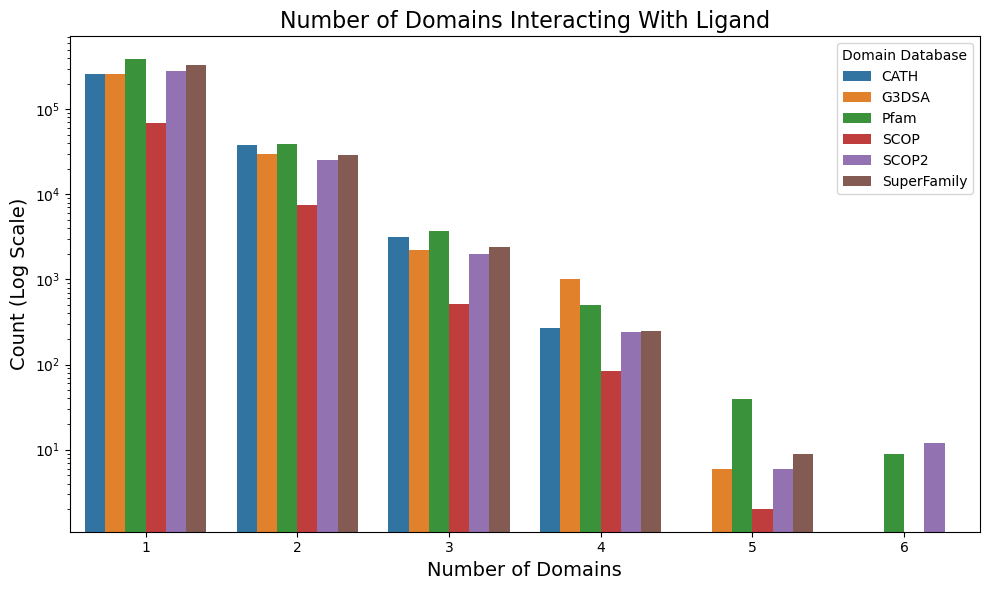

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))  # Set the figure size

# Create the barplot
sns.barplot(data=ndomains, x="num_domains", y="count", hue="xref_db", ax=ax)

# Set the y-axis to logarithmic scale
ax.set_yscale('log')

# Add title and labels
ax.set_title('Number of Domains Interacting With Ligand', fontsize=16)
ax.set_xlabel('Number of Domains', fontsize=14)
ax.set_ylabel('Count (Log Scale)', fontsize=14)

# Improve legend visibility
ax.legend(title='Domain Database', loc='upper right')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(f"{analysis_output_path}/figures/domain_db_counts/domain_db_count.svg")
#plt.show()


In [19]:
ndomains["domain_sum"] = ndomains.groupby("xref_db")["count"].transform("sum")
ndomains["perc_all"] = ndomains["count"] / ndomains["domain_sum"]
print(f"""
One domain interactions make up {ndomains.loc[ndomains.num_domains <= 1].groupby("xref_db").perc_all.sum().mean()}% of interactions
One or two domain interactions make up {ndomains.loc[ndomains.num_domains <= 2].groupby("xref_db").perc_all.sum().mean()}% of interactions
""")


One domain interactions make up 0.8941914698046478% of interactions
One or two domain interactions make up 0.9908655923256896% of interactions



The majority of ligands are bound by only one domain, and the number bound by 3 or more is very low. We can therefore try to optimise partner interaction thresholds for two domain situations.

Despite most proteins being multidomain, for all domain databases, ligand interactions are to 1 (>89.4) or 1/2 domains for > 99.1% of ligands.

## Domain interaction inequality

A key aspect to determining the domain interaction modes is the inequality between domains in the interactions. For example, in some multi domain interactions, one domain may provide 90% of the contacts, and the other 10%. Or they may have approximately similar interaction contirbutiosn e.g. 48% - 50%. Understanding how often these inequal domain contributions occur, and what the distributions look like, could help to set the boundaries of interaction modes.

In [21]:
cath_dom_perc_list = cath[["uniqueID", "domain_accession", "domain_contact_perc"]].groupby("uniqueID").agg({"domain_contact_perc": list}).reset_index()
cath_dom_perc_list["gini_index"] = cath_dom_perc_list["domain_contact_perc"].apply(lambda x: gini(x)) 
cath_dom_perc_list["num_domains"] = cath_dom_perc_list["domain_contact_perc"].str.len()

pfam_dom_perc_list = pfam[["uniqueID", "domain_accession", "domain_contact_perc"]].groupby("uniqueID").agg({"domain_contact_perc": list}).reset_index()
pfam_dom_perc_list["gini_index"] = pfam_dom_perc_list["domain_contact_perc"].apply(lambda x: gini(x))
pfam_dom_perc_list["num_domains"] = pfam_dom_perc_list["domain_contact_perc"].str.len()

scop_dom_perc_list = scop[["uniqueID", "domain_accession", "domain_contact_perc"]].groupby("uniqueID").agg({"domain_contact_perc": list}).reset_index()
scop_dom_perc_list["gini_index"] = scop_dom_perc_list["domain_contact_perc"].apply(lambda x: gini(x)) 
scop_dom_perc_list["num_domains"] = scop_dom_perc_list["domain_contact_perc"].str.len()

gene3dsa_dom_perc_list = gene3dsa[["uniqueID", "domain_accession", "domain_contact_perc"]].groupby("uniqueID").agg({"domain_contact_perc": list}).reset_index()
gene3dsa_dom_perc_list["gini_index"] = gene3dsa_dom_perc_list["domain_contact_perc"].apply(lambda x: gini(x)) 
gene3dsa_dom_perc_list["num_domains"] = gene3dsa_dom_perc_list["domain_contact_perc"].str.len()

superfamily_dom_perc_list = superfamily[["uniqueID", "domain_accession", "domain_contact_perc"]].groupby("uniqueID").agg({"domain_contact_perc": list}).reset_index()
superfamily_dom_perc_list["gini_index"] = superfamily_dom_perc_list["domain_contact_perc"].apply(lambda x: gini(x)) 
superfamily_dom_perc_list["num_domains"] = superfamily_dom_perc_list["domain_contact_perc"].str.len()

scop2_sf_dom_perc_list = scop2_sf[["uniqueID", "domain_accession", "domain_contact_perc"]].groupby("uniqueID").agg({"domain_contact_perc": list}).reset_index()
scop2_sf_dom_perc_list["gini_index"] = scop2_sf_dom_perc_list["domain_contact_perc"].apply(lambda x: gini(x)) 
scop2_sf_dom_perc_list["num_domains"] = scop2_sf_dom_perc_list["domain_contact_perc"].str.len()

In [22]:
pfam_dom_perc_list["type"] = "pfam"
cath_dom_perc_list["type"] = "cath"
scop_dom_perc_list["type"] = "scop"
gene3dsa_dom_perc_list["type"] = "gene3d"
superfamily_dom_perc_list["type"] = "superfamily"
scop2_sf_dom_perc_list["type"] = "scop2_sf"

In [23]:
combined_dom_perc_list = pd.concat([cath_dom_perc_list, pfam_dom_perc_list, scop_dom_perc_list, gene3dsa_dom_perc_list])

Gini over 0.4 shows relative inequality, 0.5 absolute inequality.

In [24]:
cath2 = cath_dom_perc_list.loc[(cath_dom_perc_list.num_domains == 2) & (cath_dom_perc_list.gini_index > 0.4)].domain_contact_perc.apply(lambda x: min(x)).mean() * 100
cath3 = cath_dom_perc_list.loc[(cath_dom_perc_list.num_domains == 3) & (cath_dom_perc_list.gini_index > 0.4)].domain_contact_perc.apply(lambda x: min(x)).mean() * 100
cath4 = cath_dom_perc_list.loc[(cath_dom_perc_list.num_domains == 4) & (cath_dom_perc_list.gini_index > 0.4)].domain_contact_perc.apply(lambda x: min(x)).mean() * 100

pfam2 = pfam_dom_perc_list.loc[(pfam_dom_perc_list.num_domains == 2) & (pfam_dom_perc_list.gini_index > 0.4)].domain_contact_perc.apply(lambda x: min(x)).mean() * 100
pfam3 = pfam_dom_perc_list.loc[(pfam_dom_perc_list.num_domains == 3) & (pfam_dom_perc_list.gini_index > 0.4)].domain_contact_perc.apply(lambda x: min(x)).mean() * 100
pfam4 = pfam_dom_perc_list.loc[(pfam_dom_perc_list.num_domains == 4) & (pfam_dom_perc_list.gini_index > 0.4)].domain_contact_perc.apply(lambda x: min(x)).mean() * 100

scop2 = scop_dom_perc_list.loc[(scop_dom_perc_list.num_domains == 2) & (scop_dom_perc_list.gini_index > 0.4)].domain_contact_perc.apply(lambda x: min(x)).mean() * 100
scop3 = scop_dom_perc_list.loc[(scop_dom_perc_list.num_domains == 3) & (scop_dom_perc_list.gini_index > 0.4)].domain_contact_perc.apply(lambda x: min(x)).mean() * 100
scop4 = scop_dom_perc_list.loc[(scop_dom_perc_list.num_domains == 4) & (scop_dom_perc_list.gini_index > 0.4)].domain_contact_perc.apply(lambda x: min(x)).mean() * 100

gene3d2 = gene3dsa_dom_perc_list.loc[(gene3dsa_dom_perc_list.num_domains == 2) & (gene3dsa_dom_perc_list.gini_index > 0.4)].domain_contact_perc.apply(lambda x: min(x)).mean() * 100
gene3d3 = gene3dsa_dom_perc_list.loc[(gene3dsa_dom_perc_list.num_domains == 3) & (gene3dsa_dom_perc_list.gini_index > 0.4)].domain_contact_perc.apply(lambda x: min(x)).mean() * 100
gene3d4 = gene3dsa_dom_perc_list.loc[(gene3dsa_dom_perc_list.num_domains == 4) & (gene3dsa_dom_perc_list.gini_index > 0.4)].domain_contact_perc.apply(lambda x: min(x)).mean() * 100

superfamily2 = superfamily_dom_perc_list.loc[(superfamily_dom_perc_list.num_domains == 2) & (superfamily_dom_perc_list.gini_index > 0.4)].domain_contact_perc.apply(lambda x: min(x)).mean() * 100
superfamily3 = superfamily_dom_perc_list.loc[(superfamily_dom_perc_list.num_domains == 3) & (superfamily_dom_perc_list.gini_index > 0.4)].domain_contact_perc.apply(lambda x: min(x)).mean() * 100
superfamily4 = superfamily_dom_perc_list.loc[(superfamily_dom_perc_list.num_domains == 4) & (superfamily_dom_perc_list.gini_index > 0.4)].domain_contact_perc.apply(lambda x: min(x)).mean() * 100

scop2sf2 = scop2_sf_dom_perc_list.loc[(scop2_sf_dom_perc_list.num_domains == 2) & (scop2_sf_dom_perc_list.gini_index > 0.4)].domain_contact_perc.apply(lambda x: min(x)).mean() * 100
scop2sf3 = scop2_sf_dom_perc_list.loc[(scop2_sf_dom_perc_list.num_domains == 3) & (scop2_sf_dom_perc_list.gini_index > 0.4)].domain_contact_perc.apply(lambda x: min(x)).mean() * 100
scop2sf4 = scop2_sf_dom_perc_list.loc[(scop2_sf_dom_perc_list.num_domains == 4) & (scop2_sf_dom_perc_list.gini_index > 0.4)].domain_contact_perc.apply(lambda x: min(x)).mean() * 100

print("mean2")
print((cath2 + pfam2 + superfamily2 + gene3d2 + scop2sf2)/5)
print("mean3")
print((cath3 + pfam3 + superfamily3 + gene3d3 + scop2sf3)/5)
print("mean4")
print((cath4 + pfam4 + superfamily4 + gene3d4 + scop2sf4)/5)

mean2
6.943058523943725
mean3
7.496788313336696
mean4
4.718780652664296


In [30]:
###Producing a table of the percetnages for each of these domain types in procgograph
domain_contact_types_total = """
MATCH (cd:cathDomain)-[:INTERACTS_WITH_LIGAND]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as total_domains, "CATH" as domain_type UNION
MATCH (cd:gene3dDomain)-[:INTERACTS_WITH_LIGAND]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as total_domains, "Gene3D" as domain_type UNION
MATCH (cd:scopDomain)-[:INTERACTS_WITH_LIGAND]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as total_domains, "SCOP" as domain_type UNION
MATCH (cd:pfamDomain)-[:INTERACTS_WITH_LIGAND]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as total_domains, "Pfam" as domain_type UNION
MATCH (cd:superfamilyDomain)-[:INTERACTS_WITH_LIGAND]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as total_domains, "Superfamily" as domain_type UNION
MATCH (cd:scop2sfDomain)-[:INTERACTS_WITH_LIGAND]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as total_domains, "SCOP2" as domain_type
"""

domain_contact_types_total_result = pd.DataFrame([dict(_) for _ in conn.query(query = domain_contact_types_total, db='neo4j')], columns = ["total_domains", "domain_type"])

domain_contact_types_table = """
MATCH (cd:cathDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "exclusive"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "exclusive" as type, "CATH" as domain_type UNION
MATCH (cd:cathDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "dominant"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "dominant" as type, "CATH" as domain_type UNION
MATCH (cd:cathDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "major"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "major" as type, "CATH" as domain_type UNION
MATCH (cd:cathDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "major_partner"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "major_partner" as type, "CATH" as domain_type UNION
MATCH (cd:cathDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "partner"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "partner" as type, "CATH" as domain_type UNION
MATCH (cd:cathDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "minor"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "minor" as type, "CATH" as domain_type UNION
MATCH (cd:gene3dDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "exclusive"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "exclusive" as type, "Gene3D" as domain_type UNION
MATCH (cd:gene3dDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "dominant"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "dominant" as type, "Gene3D" as domain_type UNION
MATCH (cd:gene3dDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "major"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "major" as type, "Gene3D" as domain_type UNION
MATCH (cd:gene3dDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "major_partner"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "major_partner" as type, "Gene3D" as domain_type UNION
MATCH (cd:gene3dDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "partner"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "partner" as type, "Gene3D" as domain_type UNION
MATCH (cd:gene3dDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "minor"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "minor" as type, "Gene3D" as domain_type UNION
MATCH (cd:scopDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "exclusive"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "exclusive" as type, "SCOP" as domain_type UNION
MATCH (cd:scopDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "dominant"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "dominant" as type, "SCOP" as domain_type UNION
MATCH (cd:scopDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "major"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "major" as type, "SCOP" as domain_type UNION
MATCH (cd:scopDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "major_partner"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "major_partner" as type, "SCOP" as domain_type UNION
MATCH (cd:scopDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "partner"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "partner" as type, "SCOP" as domain_type UNION
MATCH (cd:scopDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "minor"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "minor" as type, "SCOP" as domain_type UNION
MATCH (cd:pfamDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "exclusive"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "exclusive" as type, "Pfam" as domain_type UNION
MATCH (cd:pfamDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "dominant"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "dominant" as type, "Pfam" as domain_type UNION
MATCH (cd:pfamDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "major"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "major" as type, "Pfam" as domain_type UNION
MATCH (cd:pfamDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "major_partner"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "major_partner" as type, "Pfam" as domain_type UNION
MATCH (cd:pfamDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "partner"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "partner" as type, "Pfam" as domain_type UNION
MATCH (cd:pfamDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "minor"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "minor" as type, "Pfam" as domain_type UNION
MATCH (cd:superfamilyDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "exclusive"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "exclusive" as type, "Superfamily" as domain_type UNION
MATCH (cd:superfamilyDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "dominant"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "dominant" as type, "Superfamily" as domain_type UNION
MATCH (cd:superfamilyDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "major"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "major" as type, "Superfamily" as domain_type UNION
MATCH (cd:superfamilyDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "major_partner"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "major_partner" as type, "Superfamily" as domain_type UNION
MATCH (cd:superfamilyDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "partner"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "partner" as type, "Superfamily" as domain_type UNION
MATCH (cd:superfamilyDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "minor"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "minor" as type, "Superfamily" as domain_type UNION
MATCH (cd:scop2sfDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "exclusive"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "exclusive" as type, "SCOP2-SF" as domain_type UNION
MATCH (cd:scop2sfDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "dominant"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "dominant" as type, "SCOP2-SF" as domain_type UNION
MATCH (cd:scop2sfDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "major"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "major" as type, "SCOP2-SF" as domain_type UNION
MATCH (cd:scop2sfDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "major_partner"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "major_partner" as type, "SCOP2-SF" as domain_type UNION
MATCH (cd:scop2sfDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "partner"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "partner" as type, "SCOP2-SF" as domain_type UNION
MATCH (cd:scop2sfDomain)-[:INTERACTS_WITH_LIGAND {interactionMode: "minor"}]->(be:boundEntity) RETURN COUNT(DISTINCT(cd.domain)) as num_doms, "minor" as type, "SCOP2-SF" as domain_type
"""


domain_contact_types_table_result = pd.DataFrame([dict(_) for _ in conn.query(query = domain_contact_types_table, db='neo4j')])

domain_contact_types_table_result_merged = domain_contact_types_table_result.merge(domain_contact_types_total_result, on = "domain_type", how = "left")

domain_contact_types_table_result_merged["perc_domains"] = domain_contact_types_table_result_merged["num_doms"]/domain_contact_types_table_result_merged["total_domains"]

domain_contact_types_table_result_merged.to_csv(f"{analysis_output_path}/tables/dom_contact_types_breakdown.csv", index = False)

domain_contact_types_table_result_merged

,num_doms,type,domain_type,total_domains,perc_domains
0,125222,exclusive,CATH,162135.0,0.772332
1,2431,dominant,CATH,162135.0,0.014994
2,46,major,CATH,162135.0,0.000284
3,34382,major_partner,CATH,162135.0,0.212058
4,37131,partner,CATH,162135.0,0.229013
5,3008,minor,CATH,162135.0,0.018552
6,121823,exclusive,Gene3D,144743.0,0.841650
7,731,dominant,Gene3D,144743.0,0.005050
8,14,major,Gene3D,144743.0,0.000097
9,26567,major_partner,Gene3D,144743.0,0.183546


### Surfaces Domain interaction analysis

In [31]:
##Load the minor domain results

_2ag1 = pd.read_csv("surfaces_domain_results/List_2ag1_output.txt", header=None, names=["residue", "ligand", "contact_value"])
_2ag1[["res", "pos", "chain"]] = _2ag1.residue.str.extract("([A-z]{3})(\d+)([A-z]+)", expand = True)
_2ag1["pos"] = _2ag1["pos"].astype("int")
_2ag1_A01_range = list(range(4,183 + 1))
_2ag1_B03_range = list(range(364, 555 + 1))

_2ag1_minor = _2ag1.loc[(_2ag1.pos.isin(_2ag1_A01_range)) & (_2ag1.chain == "A")].contact_value.sum()
_2ag1_dominant = _2ag1.loc[(_2ag1.pos.isin(_2ag1_B03_range)) & (_2ag1.chain == "B")].contact_value.sum()

_2y5l = pd.read_csv("surfaces_domain_results/List_2y5l_output.txt", header=None, names=["residue", "ligand", "contact_value"])
_2y5l[["res", "pos", "chain"]] = _2y5l.residue.str.extract("([A-z]{3})(\d+)([A-z]+)", expand = True)
_2y5l["pos"] = _2y5l["pos"].astype("int")
_2y5l_A01_range = list(range(9, 199 + 1))
_2y5l_C01_range = list(range(9, 199 + 1))

_2y5l_dominant = _2y5l.loc[(_2y5l.pos.isin(_2y5l_A01_range)) & (_2y5l.chain == "A")].contact_value.sum()
_2y5l_minor = _2y5l.loc[(_2y5l.pos.isin(_2y5l_C01_range)) & (_2y5l.chain == "C")].contact_value.sum()

_3n6e = pd.read_csv("surfaces_domain_results/List_3n6e_output.txt", header=None, names=["residue", "ligand", "contact_value"])
_3n6e[["res", "pos", "chain"]] = _3n6e.residue.str.extract("([A-z]{3})(\d+)([A-z]+)", expand = True)
_3n6e["pos"] = _3n6e["pos"].astype("int")
_3n6e_A01_range = list(range(84, 201 + 1)) + list(range(228, 238 + 1)) + list(range(342, 356 + 1)) + list(range(426,450 + 1))
_3n6e_A03_range = list(range(314, 336 + 1)) + list(range(359, 424 + 1))

_3n6e_minor = _3n6e.loc[(_3n6e.pos.isin(_3n6e_A03_range)) & (_3n6e.chain == "A")].contact_value.sum()
_3n6e_dominant = _3n6e.loc[(_3n6e.pos.isin(_3n6e_A01_range)) & (_3n6e.chain == "A")].contact_value.sum()

_4kcn = pd.read_csv("surfaces_domain_results/List_4kcn_output.txt", header=None, names=["residue", "ligand", "contact_value"])
_4kcn[["res", "pos", "chain"]] = _4kcn.residue.str.extract("([A-z]{3})(\d+)([A-z]+)", expand = True)
_4kcn["pos"] = _4kcn["pos"].astype("int")
_4kcn_A01_range = list(range(314, 430 + 1)) + list(range(457, 467 + 1)) + list(range(571, 585 + 1)) + list(range(655, 679 + 1))
_4kcn_A03_range = list(range(543, 565 + 1)) + list(range(588, 653 + 1))

_4kcn_dominant = _4kcn.loc[(_4kcn.pos.isin(_4kcn_A01_range)) & (_4kcn.chain == "A")].contact_value.sum()
_4kcn_minor = _4kcn.loc[(_4kcn.pos.isin(_4kcn_A03_range)) & (_4kcn.chain == "A")].contact_value.sum()

_5g6k = pd.read_csv("surfaces_domain_results/List_5g6k_output.txt", header=None, names=["residue", "ligand", "contact_value"])
_5g6k[["res", "pos", "chain"]] = _5g6k.residue.str.extract("([A-z]{3})(\d+)([A-z]+)", expand = True)
_5g6k["pos"] = _5g6k["pos"].astype("int")
_5g6k_A01_range = list(range(2,81 + 1)) + list(range(108, 118 + 1)) + list(range(222,236 + 1)) + list(range(306, 330 + 1))
_5g6k_A03_range = list(range(194,216 + 1)) + list(range(239, 304 + 1))
_5g6k_dominant = _5g6k.loc[(_5g6k.pos.isin(_5g6k_A01_range)) & (_5g6k.chain == "A")].contact_value.sum()
_5g6k_minor = _5g6k.loc[(_5g6k.pos.isin(_5g6k_A03_range)) & (_5g6k.chain == "A")].contact_value.sum()

_6ngu = pd.read_csv("surfaces_domain_results/List_6ngu_output.txt", header=None, names=["residue", "ligand", "contact_value"])
_6ngu[["res", "pos", "chain"]] = _6ngu.residue.str.extract("([A-z]{3})(\d+)([A-z]+)", expand = True)
_6ngu["pos"] = _6ngu["pos"].astype("int")
_6ngu_A01_range = list(range(314,430 + 1)) + list(range(457,467 + 1)) + list(range(571, 585 + 1)) + list(range(655,679 + 1))
_6ngu_A03_range = list(range(543,565 + 1)) + list(range(588, 653 + 1))
_6ngu_dominant = _6ngu.loc[(_6ngu.pos.isin(_6ngu_A01_range)) & (_6ngu.chain == "A")].contact_value.sum()
_6ngu_minor = _6ngu.loc[(_6ngu.pos.isin(_6ngu_A03_range)) & (_6ngu.chain == "A")].contact_value.sum()

_3nlf = pd.read_csv("surfaces_domain_results/List_3nlf_output.txt", header=None, names=["residue", "ligand", "contact_value"])
_3nlf[["res", "pos", "chain"]] = _3nlf.residue.str.extract("([A-z]{3})(\d+)([A-z]+)", expand = True)
_3nlf["pos"] = _3nlf["pos"].astype("int")
_3nlf_B01_range = list(range(84,201 + 1)) + list(range(228,238 + 1)) + list(range(342,356 + 1)) + list(range(426,450 + 1))
_3nlf_B03_range = list(range(314,336 + 1)) + list(range(359, 424 + 1))
_3nlf_dominant = _3nlf.loc[(_3nlf.pos.isin(_3nlf_B01_range)) & (_3nlf.chain == "B")].contact_value.sum()
_3nlf_minor = _3nlf.loc[(_3nlf.pos.isin(_3nlf_B03_range)) & (_3nlf.chain == "B")].contact_value.sum()

_3udm = pd.read_csv("surfaces_domain_results/List_3udm_output.txt", header=None, names=["residue", "ligand", "contact_value"])
_3udm[["res", "pos", "chain"]] = _3udm.residue.str.extract("([A-z]{3})(\d+)([A-z]+)", expand = True)
_3udm["pos"] = _3udm["pos"].astype("int")
_3udm_A01_range = list(range(14,146 + 1))
_3udm_A02_range = list(range(147,398 + 1)) 
_3udm_dominant = _3udm.loc[(_3udm.pos.isin(_3udm_A01_range)) & (_3udm.chain == "A")].contact_value.sum()
_3udm_minor = _3udm.loc[(_3udm.pos.isin(_3udm_A02_range)) & (_3udm.chain == "A")].contact_value.sum()

_4cww = pd.read_csv("surfaces_domain_results/List_4cww_output.txt", header=None, names=["residue", "ligand", "contact_value"])
_4cww[["res", "pos", "chain"]] = _4cww.residue.str.extract("([A-z]{3})(\d+)([A-z]+)", expand = True)
_4cww["pos"] = _4cww["pos"].astype("int")
_4cww_A01_range = list(range(84,201 + 1)) + list(range(228,238 + 1)) + list(range(342,356 + 1)) + list(range(426,450 + 1))
_4cww_A03_range = list(range(314,336 + 1)) + list(range(359,424 + 1))
_4cww_dominant = _4cww.loc[(_4cww.pos.isin(_4cww_A01_range)) & (_4cww.chain == "A")].contact_value.sum()
_4cww_minor = _4cww.loc[(_4cww.pos.isin(_4cww_A03_range)) & (_4cww.chain == "A")].contact_value.sum()

_4f8y = pd.read_csv("surfaces_domain_results/List_4f8y_output.txt", header=None, names=["residue", "ligand", "contact_value"])
_4f8y[["res", "pos", "chain"]] = _4f8y.residue.str.extract("([A-z]{3})(\d+)([A-z]+)", expand = True)
_4f8y["pos"] = _4f8y["pos"].astype("int")
_4f8y_A00_range = list(range(1,196 + 1))
_4f8y_B00_range = list(range(1,188 + 1))
_4f8y_dominant = _4f8y.loc[(_4f8y.pos.isin(_4f8y_A00_range)) & (_4f8y.chain == "A")].contact_value.sum()
_4f8y_minor = _4f8y.loc[(_4f8y.pos.isin(_4f8y_B00_range)) & (_4f8y.chain == "B")].contact_value.sum()

minor_list = [_2ag1_minor, _2y5l_minor, _3n6e_minor, _4kcn_minor, _5g6k_minor, _6ngu_minor, _3nlf_minor, _3udm_minor, _4cww_minor, _4f8y_minor]

print(sum(minor_list) / len(minor_list))

-0.41472666892312793


In [32]:
## load the low partner domain results

_5iw8 = pd.read_csv("surfaces_domain_results/List_5iw8_output.txt", header=None, names=["residue", "ligand", "contact_value"])
_5iw8[["res", "pos", "chain"]] = _5iw8.residue.str.extract("([A-z]{3})(\d+)([A-z]+)", expand = True)
_5iw8["pos"] = _5iw8["pos"].astype("int")
_5iw8_A01_range = list(range(3,44 + 1)) + list(range(165,317 + 1))
_5iw8_A02_range = list(range(45, 151 + 1))

_5iw8_high = _5iw8.loc[(_5iw8.pos.isin(_5iw8_A01_range)) & (_5iw8.chain == "A")].contact_value.sum()
_5iw8_med = _5iw8.loc[(_5iw8.pos.isin(_5iw8_A02_range)) & (_5iw8.chain == "A")].contact_value.sum()

_6dep = pd.read_csv("surfaces_domain_results/List_6dep_output.txt", header=None, names=["residue", "ligand", "contact_value"])
_6dep[["res", "pos", "chain"]] = _6dep.residue.str.extract("([A-z]{3})(\d+)([A-z]+)", expand = True)
_6dep["pos"] = _6dep["pos"].astype("int")
_6dep_A02_range = list(range(266,455 + 1))
_6dep_A03_range = list(range(456,683 + 1))

_6dep_high = _6dep.loc[(_6dep.pos.isin(_6dep_A02_range)) & (_6dep.chain == "A")].contact_value.sum()
_6dep_med = _6dep.loc[(_6dep.pos.isin(_6dep_A03_range)) & (_6dep.chain == "A")].contact_value.sum()

_6q94 = pd.read_csv("surfaces_domain_results/List_6q94_output.txt", header=None, names=["residue", "ligand", "contact_value"])
_6q94[["res", "pos", "chain"]] = _6q94.residue.str.extract("([A-z]{3})(\d+)([A-z]+)", expand = True)
_6q94["pos"] = _6q94["pos"].astype("int")
_6q94_D01_range = list(range(23,214 + 1)) + list(range(250,277 + 1)) + list(range(329, 349 + 1))
_6q94_F01_range = list(range(23,214 + 1)) + list(range(250, 277 + 1)) + list(range(329, 349 + 1))

_6q94_high = _6q94.loc[(_6q94.pos.isin(_6q94_D01_range)) & (_6q94.chain == "D")].contact_value.sum()
_6q94_med = _6q94.loc[(_6q94.pos.isin(_6q94_F01_range)) & (_6q94.chain == "F")].contact_value.sum()

_1orw = pd.read_csv("surfaces_domain_results/List_1orw_output.txt", header=None, names=["residue", "ligand", "contact_value"])
_1orw[["res", "pos", "chain"]] = _1orw.residue.str.extract("([A-z]{3})(\d+)([A-z]+)", expand = True)
_1orw["pos"] = _1orw["pos"].astype("int")
_1orw_D01_range = list(range(39,508 + 1))
_1orw_D02_range = list(range(509,766 + 1))

_1orw_high = _1orw.loc[(_1orw.pos.isin(_1orw_D01_range)) & (_1orw.chain == "D")].contact_value.sum()
_1orw_med = _1orw.loc[(_1orw.pos.isin(_1orw_D02_range)) & (_1orw.chain == "D")].contact_value.sum()

_1n95 = pd.read_csv("surfaces_domain_results/List_1n95_output.txt", header=None, names=["residue", "ligand", "contact_value"])
_1n95[["res", "pos", "chain"]] = _1n95.residue.str.extract("([A-z]{3})(\d+)([A-z]+)", expand = True)
_1n95["pos"] = _1n95["pos"].astype("int")
_1n95_A00_range = list(range(55,366 + 1))
_1n95_B00_range = list(range(23,423 + 1))

_1n95_high = _1n95.loc[(_1n95.pos.isin(_1n95_B00_range)) & (_1n95.chain == "B")].contact_value.sum()
_1n95_med = _1orw.loc[(_1orw.pos.isin(_1n95_A00_range)) & (_1n95.chain == "A")].contact_value.sum()

_4hfm = pd.read_csv("surfaces_domain_results/List_4hfm_output.txt", header=None, names=["residue", "ligand", "contact_value"])
_4hfm[["res", "pos", "chain"]] = _4hfm.residue.str.extract("([A-z]{3})(\d+)([A-z]+)", expand = True)
_4hfm["pos"] = _4hfm["pos"].astype("int")
_4hfm_B01_range = list(range(2,132 + 1)) + list(range(310,343 + 1))
_4hfm_B02_range = list(range(133, 309 + 1))

_4hfm_med = _4hfm.loc[(_4hfm.pos.isin(_4hfm_B01_range)) & (_4hfm.chain == "B")].contact_value.sum()
_4hfm_high = _4hfm.loc[(_4hfm.pos.isin(_4hfm_B02_range)) & (_4hfm.chain == "B")].contact_value.sum()

_2o2q = pd.read_csv("surfaces_domain_results/List_2o2q_output.txt", header=None, names=["residue", "ligand", "contact_value"])
_2o2q[["res", "pos", "chain"]] = _2o2q.residue.str.extract("([A-z]{3})(\d+)([A-z]+)", expand = True)
_2o2q["pos"] = _2o2q["pos"].astype("int")
_2o2q_C01_range = list(range(410,675 + 1)) + list(range(868, 902 + 1))
_2o2q_C02_range = list(range(676,867 + 1))

_2o2q_high = _2o2q.loc[(_2o2q.pos.isin(_2o2q_C01_range)) & (_2o2q.chain == "C")].contact_value.sum()
_2o2q_med = _2o2q.loc[(_2o2q.pos.isin(_2o2q_C02_range)) & (_2o2q.chain == "C")].contact_value.sum()

_1v2p = pd.read_csv("surfaces_domain_results/List_1v2p_output.txt", header=None, names=["residue", "ligand", "contact_value"])
_1v2p[["res", "pos", "chain"]] = _1v2p.residue.str.extract("([A-z]{3})(\d+)([A-z]+)", expand = True)
_1v2p["pos"] = _1v2p["pos"].astype("int")
_1v2p_T01_range = list(range(16,27 + 1)) + list(range(121, 232 + 1))
_1v2p_T02_range = list(range(28,120 + 1)) + list(range(233,245 + 1))

_1v2p_med = _1v2p.loc[(_1v2p.pos.isin(_1v2p_T01_range)) & (_1v2p.chain == "T")].contact_value.sum()
_1v2p_high = _1v2p.loc[(_1v2p.pos.isin(_1v2p_T02_range)) & (_1v2p.chain == "T")].contact_value.sum()

_3g1u = pd.read_csv("surfaces_domain_results/List_3g1u_output.txt", header=None, names=["residue", "ligand", "contact_value"])
_3g1u[["res", "pos", "chain"]] = _3g1u.residue.str.extract("([A-z]{3})(\d+)([A-z]+)", expand = True)
_3g1u["pos"] = _3g1u["pos"].astype("int")
_3g1u_D01_range = list(range(3,191 + 1)) + list(range(352, 409 + 1))
_3g1u_D02_range = list(range(192, 351 + 1))

_3g1u_high = _3g1u.loc[(_3g1u.pos.isin(_3g1u_D01_range)) & (_3g1u.chain == "D")].contact_value.sum()
_3g1u_med = _3g1u.loc[(_3g1u.pos.isin(_3g1u_D02_range)) & (_3g1u.chain == "D")].contact_value.sum()

_3hu2 = pd.read_csv("surfaces_domain_results/List_3hu2_output.txt", header=None, names=["residue", "ligand", "contact_value"])
_3hu2[["res", "pos", "chain"]] = _3hu2.residue.str.extract("([A-z]{3})(\d+)([A-z]+)", expand = True)
_3hu2["pos"] = _3hu2["pos"].astype("int")
_3hu2_D03_range = list(range(201, 370 + 1))
_3hu2_D04_range = list(range(371, 463 + 1))

_3hu2_high = _3hu2.loc[(_3hu2.pos.isin(_3hu2_D03_range)) & (_3hu2.chain == "D")].contact_value.sum()
_3hu2_med = _3hu2.loc[(_3hu2.pos.isin(_3hu2_D04_range)) & (_3hu2.chain == "D")].contact_value.sum()

med_list = [_5iw8_med, _6dep_med, _6q94_med, _1orw_med, _1n95_med, _4hfm_med, _2o2q_med, _1v2p_med, _3g1u_med, _3hu2_med] 

print(sum(med_list) / len(med_list))

-2.136489560246929


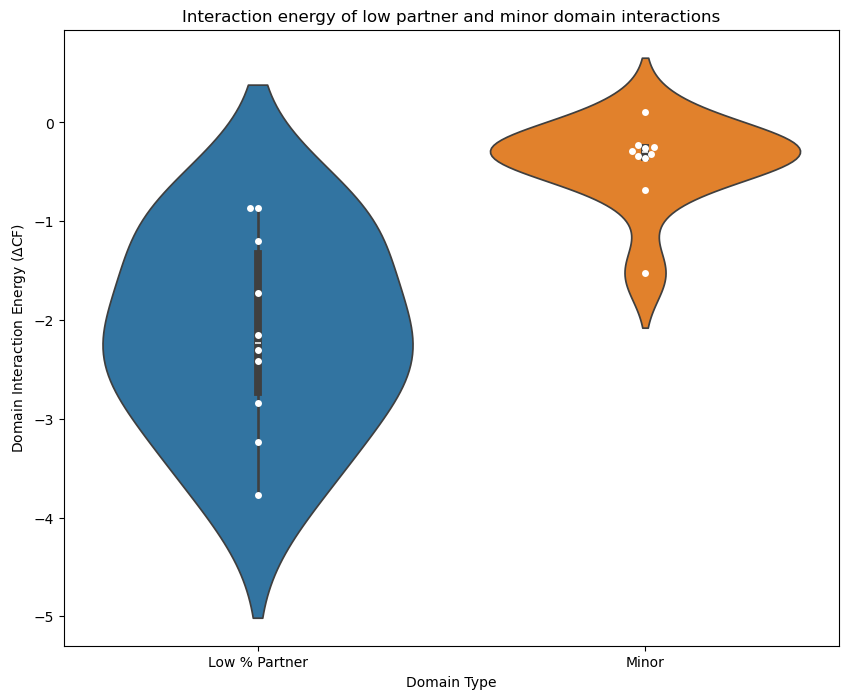

In [33]:
##plot the results

med_df = pd.DataFrame({"interaction_energy": med_list, "type": "Low % Partner"})
min_df = pd.DataFrame({"interaction_energy": minor_list, "type": "Minor"})
all_df = pd.concat([med_df, min_df])

plt.figure(figsize=(10, 8))
#sns.violinplot(data = all_df, y = "interaction_energy", x = "type", hue = "type")
sns.boxplot(data = all_df, y = "interaction_energy", x = "type" , hue = "type")
plt.title('Interaction energy of low partner and minor domain interactions')
plt.ylabel(r'Domain Interaction Energy ($\Delta$CF)')
plt.xlabel('Domain Type')
plt.savefig(f"{analysis_output_path}/figures/surfaces/interaction_energy_boxplot.svg")

In [34]:
import numpy as np
from scipy.stats import ttest_ind

# Sample data
group1 = np.array(med_list)
group2 = np.array(minor_list)

# Perform the independent t-test
t_stat, p_value = ttest_ind(group1, group2)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: -5.051864967796623
P-value: 8.299466664713548e-05
